In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures
from sklearn.linear_model import SGDClassifier, SGDRegressor, TweedieRegressor, RidgeCV
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.metrics import auc, mean_squared_error
from sklearn.pipeline import Pipeline

rng = np.random.default_rng()
sns.set_theme()

In [15]:
from scipy import stats

In [137]:
lambda_ = np.mean(df["ClaimNb"])
counts = df["ClaimNb"].value_counts().sort_index()
theoretical = stats.poisson.pmf(counts.index, mu=lambda_) * counts.sum()

In [138]:
pd.DataFrame({"Observed": counts, "Theoretical": theoretical.astype(int)})

,Observed,Theoretical
ClaimNb,,
0,643953,642855
1,32178,34229
2,1784,911
3,82,16
4,7,0
5,2,0
6,1,0
8,1,0
9,1,0


In [139]:
stats.chisquare(counts, theoretical)

Power_divergenceResult(statistic=7.794970846128039e+27, pvalue=0.0)

In [23]:
gt_zero_df = df[df["ClaimAmount"] > 0]
fitted_gamma = stats.gamma.fit(gt_zero_df["ClaimAmount"])
fitted_lognormal = stats.lognorm.fit(gt_zero_df["ClaimAmount"])

In [22]:
stats.kstest(gt_zero_df["ClaimAmount"], lambda x: stats.gamma.cdf(x, *fitted_gamma))

KstestResult(statistic=0.9998472930812382, pvalue=0.0, statistic_location=1.49, statistic_sign=-1)

In [25]:
stats.kstest(
    gt_zero_df["ClaimAmount"], lambda x: stats.lognorm.cdf(x, *fitted_lognormal)
)

KstestResult(statistic=0.20460648065280734, pvalue=0.0, statistic_location=1127.91, statistic_sign=-1)

# Helper Functions

In [2]:
def lorenz_curve(pp_true, pp_pred, exposure):
    pp_true, pp_pred, exposure = (
        np.asarray(pp_true),
        np.asarray(pp_pred),
        np.asarray(exposure),
    )

    # order actual pure premium and exposure
    # by increasing predicted pure premium:
    order = np.argsort(pp_pred)
    ordered_pp = pp_true[order]
    ordered_exposure = exposure[order]

    cumulative_loss = np.cumsum(ordered_pp * ordered_exposure)
    cumulative_loss /= cumulative_loss[-1]
    exposure_percent = np.linspace(0, 1, len(exposure))
    return exposure_percent, cumulative_loss


def plot_lorenz_curve(pp_true, pp_pred, exposure):
    exp_percent, cum_loss = lorenz_curve(pp_true, pp_pred, exposure)
    # See https://en.wikipedia.org/wiki/Gini_coefficient#Definition
    model_gini = round(1 - 2 * auc(exp_percent, cum_loss), 2)
    _, cum_loss_oracle = lorenz_curve(pp_true, pp_true, exposure)
    oracle_gini = round(1 - 2 * auc(exp_percent, cum_loss_oracle), 2)

    fig, ax = plt.subplots(figsize=(8, 8))
    ax.plot(
        exp_percent, cum_loss, color="tab:blue", label=f"Model (Gini: {model_gini})"
    )
    ax.plot(
        exp_percent,
        cum_loss_oracle,
        color="tab:orange",
        alpha=0.5,
        label=f"Oracle (Gini: {oracle_gini})",
    )
    ax.plot(
        [0, 1],
        [0, 1],
        linestyle="dashed",
        color="tab:gray",
        alpha=0.5,
        label="Random (Gini: 0)",
    )
    ax.legend()
    ax.set_xlabel("Percent of Exposure")
    ax.set_ylabel("Percent of Losses")


def compute_gini(pp_true, pp_pred, exposure):
    exp_percent, cum_loss = lorenz_curve(pp_true, pp_pred, exposure)
    return 1 - 2 * auc(exp_percent, cum_loss)

# Data

In [2]:
df_freq = pd.read_csv(
    "./data/insurance/freMTPL2freq.csv",
    index_col="IDpol",
    dtype={"IDpol": int},
)

df_sev = pd.read_csv("./data/insurance/freMTPL2sev.csv").groupby("IDpol").sum()

df = df_freq.join(df_sev, how="left").fillna(0)

df["PurePremium"] = df["ClaimAmount"] / df["Exposure"]

In [128]:
trans = ColumnTransformer(
    [
        (
            "onehot",
            OneHotEncoder(),
            ["Area", "VehBrand", "VehGas", "Region"],
        ),
        # (
        #     "poly",
        #     PolynomialFeatures(degree=3),
        #     ["VehPower", "VehAge", "DrivAge", "BonusMalus", "Density"],
        # ),
        # (
        #     "poly_iteract",
        #     PolynomialFeatures(degree=3, interaction_only=True),
        #     ["VehPower", "VehAge", "DrivAge", "BonusMalus", "Density"],
        # ),
        (
            "standardscaler_numeric",
            StandardScaler(),
            ["VehPower", "VehAge", "DrivAge", "BonusMalus", "Density"],
        ),
    ],
    remainder="drop",
)

class_model = SGDClassifier(loss="log_loss", penalty="l2")
params = {"alpha": 10.0 ** np.arange(-5, 0)}

class_pipe = Pipeline(
    [
        ("transform", trans),
        (
            "sgd",
            GridSearchCV(class_model, params, cv=5, scoring="neg_log_loss", n_jobs=-1),
        ),
    ]
)

reg_model = SGDRegressor(loss="squared_error", penalty="l2")
params = {"alpha": 10.0 ** np.arange(-10, 0)}
reg_pipe = Pipeline(
    [
        ("transform", trans),
        (
            "sgd",
            GridSearchCV(
                reg_model, params, cv=5, scoring="neg_mean_squared_error", n_jobs=-1
            ),
        ),
    ]
)

# Model

In [8]:
results = {
    "gini": [],
    "oos_pp": [],
    "mse": [],
}

cv = KFold(n_splits=10)

for fold, (train, test) in enumerate(cv.split(df)):
    print(f"Fold {fold}")
    # Make data
    df_train = df.iloc[train]
    df_test = df.iloc[test]

    X_train = df_train
    X_test = df_test
    X_gtzero_train = df_train[df_train["PurePremium"] > 0]
    X_gtzero_test = df_test[df_test["PurePremium"] > 0]

    Y_train = (df_train["PurePremium"] > 0).astype(int).values
    Y_test = (df_test["PurePremium"] > 0).astype(int).values
    Y_gtzero_train = np.log(df_train[df_train["PurePremium"] > 0]["PurePremium"].values)
    Y_gtzero_test = np.log(df_test[df_test["PurePremium"] > 0]["PurePremium"].values)

    # Classification model
    class_pipe.fit(X_train, Y_train)

    # Regression model
    reg_pipe.fit(X_gtzero_train, Y_gtzero_train)

    # Out-of-sample pure premium predictions
    pp_predict = class_pipe.predict_proba(X_test)[:, 1] * np.exp(
        reg_pipe.predict(X_test)
    )
    results["oos_pp"].append(pp_predict)
    results["mse"].append(mean_squared_error(df_test["PurePremium"], pp_predict))
    results["gini"].append(
        compute_gini(df_test["PurePremium"], pp_predict, df_test["Exposure"])
    )

Fold 0
Fold 1
Fold 2
Fold 3
Fold 4
Fold 5
Fold 6
Fold 7
Fold 8
Fold 9


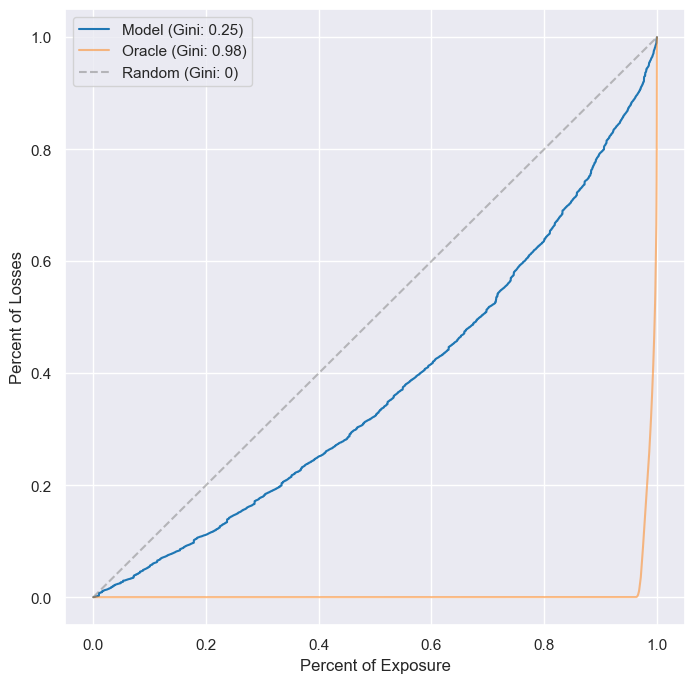

In [8]:
plot_lorenz_curve(df["PurePremium"], np.concatenate(results["oos_pp"]), df["Exposure"])

In [9]:
np.mean(results["mse"])

793973023.3179891

In [10]:
np.mean(results["gini"])

0.2319571022607557

In [12]:
np.std(results["gini"]) / np.sqrt(10)

0.024493052016862065

In [13]:
tweedie_model = TweedieRegressor(power=1.67, link="log")
params = {"alpha": 10.0 ** np.arange(-1, 4)}

tweedie_pipe = Pipeline(
    [
        ("transform", trans),
        (
            "tweedie",
            GridSearchCV(
                tweedie_model, params, cv=5, scoring="neg_mean_squared_error", n_jobs=-1
            ),
        ),
    ]
)

In [14]:
tweedie_results = {
    "gini": [],
    "oos_pp": [],
    "mse": [],
}

cv = KFold(n_splits=10)

for fold, (train, test) in enumerate(cv.split(df)):
    print(f"Fold {fold}")
    X_train = df.iloc[train]
    X_test = df.iloc[test]
    Y_train = df.iloc[train]["PurePremium"]
    Y_test = df.iloc[test]["PurePremium"]

    tweedie_pipe.fit(X_train, Y_train)
    tweedie_results["oos_pp"].append(tweedie_pipe.predict(X_test))
    tweedie_results["mse"].append(
        mean_squared_error(Y_test, tweedie_pipe.predict(X_test))
    )
    tweedie_results["gini"].append(
        compute_gini(Y_test, tweedie_pipe.predict(X_test), df.iloc[test]["Exposure"])
    )

Fold 0
Fold 1
Fold 2
Fold 3
Fold 4
Fold 5
Fold 6
Fold 7
Fold 8
Fold 9


In [15]:
np.mean(tweedie_results["gini"])

0.16191923969551617

In [18]:
np.std(tweedie_results["gini"]) / np.sqrt(10)

0.029649702118855592

In [16]:
np.mean(tweedie_results["mse"])

793859836.9824568

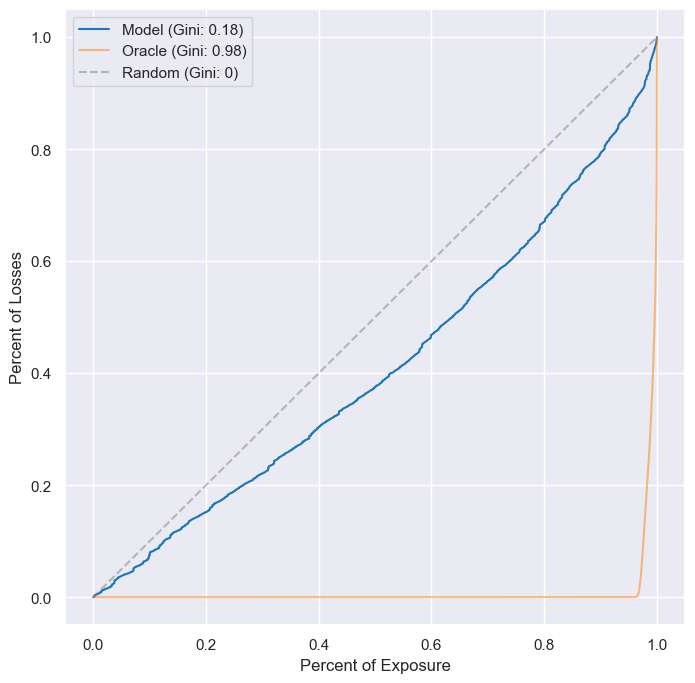

In [17]:
plot_lorenz_curve(
    df["PurePremium"], np.concatenate(tweedie_results["oos_pp"]), df["Exposure"]
)

In [ ]:
# TODO: compute gini index for models in each fold
# TODO: develop better metric than gini for assesing increase in profitability from using model
# TODO: compare models to mean-only prediction

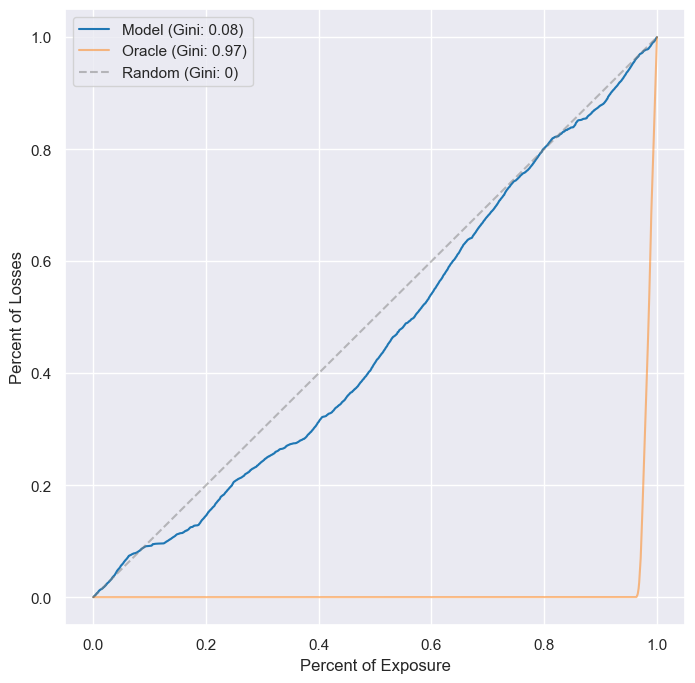

In [35]:
plot_lorenz_curve(
    df["PurePremium"],
    np.full(df["PurePremium"].shape, np.mean(df["PurePremium"])),
    df["Exposure"],
)

In [36]:
mean_squared_error(
    df["PurePremium"], np.full(df["PurePremium"].shape, np.mean(df["PurePremium"]))
)

148735.83439341432

In [8]:
freq_model = TweedieRegressor(power=1, link="log")
params = {"alpha": 10.0 ** np.arange(-1, 4)}

freq_pipe = Pipeline(
    [
        ("transform", trans),
        (
            "tweedie",
            GridSearchCV(
                freq_model, params, cv=5, scoring="neg_mean_squared_error", n_jobs=-1
            ),
        ),
    ]
)

sev_model = RidgeCV(alphas=10.0 ** np.arange(0, 5))
sev_pipe = Pipeline(
    [
        ("transform", trans),
        ("tweedie", sev_model),
    ]
)

In [30]:
freq_sev_results = {
    "gini": [],
    "oos_pp": [],
    "mse": [],
}

cv = KFold(n_splits=10)

for fold, (train, test) in enumerate(cv.split(df)):
    print(f"Fold {fold}")
    df_train = df.iloc[train]
    df_test = df.iloc[test]
    X_train = df_train
    X_test = df_test
    freq_train = df_train["ClaimNb"] / df_train["Exposure"]

    df_sev_train = df_train[df_train["ClaimAmount"] > 0]
    sev_X_train = df_sev_train
    sev_train = np.log(df_sev_train["ClaimAmount"] / df_sev_train["ClaimNb"])

    freq_pipe.fit(X_train, freq_train, tweedie__sample_weight=df_train["Exposure"])
    sev_pipe.fit(sev_X_train, sev_train)

    predict = freq_pipe.predict(X_test) * np.exp(sev_pipe.predict(X_test))
    freq_sev_results["oos_pp"].append(predict)
    freq_sev_results["mse"].append(mean_squared_error(df_test["PurePremium"], predict))
    freq_sev_results["gini"].append(
        compute_gini(df_test["PurePremium"], predict, df.iloc[test]["Exposure"])
    )

Fold 0
Fold 1
Fold 2
Fold 3
Fold 4
Fold 5
Fold 6
Fold 7
Fold 8
Fold 9


In [33]:
np.mean(freq_sev_results["mse"])

149900.9366275042

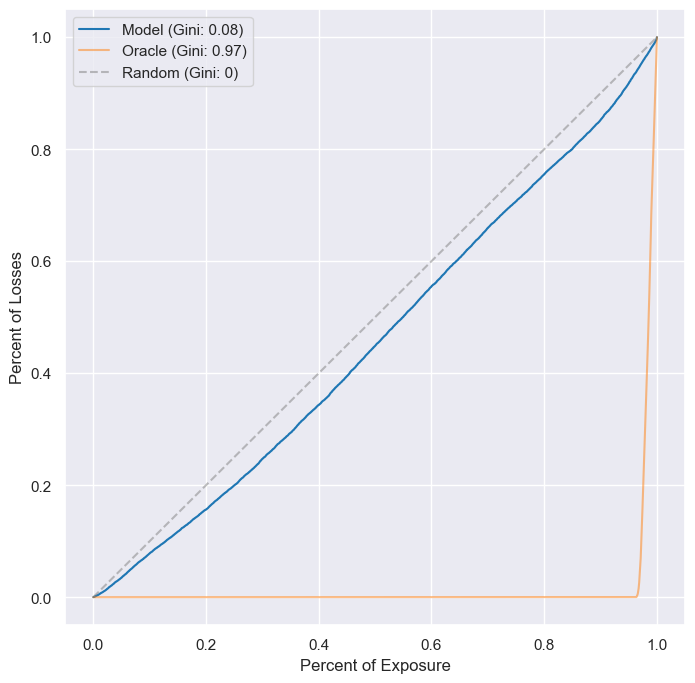

In [34]:
plot_lorenz_curve(
    df["PurePremium"], np.concatenate(freq_sev_results["oos_pp"]), df["Exposure"]
)

(array([5.45376e+05, 1.28270e+05, 4.04600e+03, 2.47000e+02, 5.30000e+01,
        1.10000e+01, 5.00000e+00, 0.00000e+00, 1.00000e+00, 4.00000e+00]),
 array([   6.17925943,  119.23755663,  232.29585384,  345.35415104,
         458.41244825,  571.47074545,  684.52904266,  797.58733986,
         910.64563707, 1023.70393427, 1136.76223148]),
 <BarContainer object of 10 artists>)

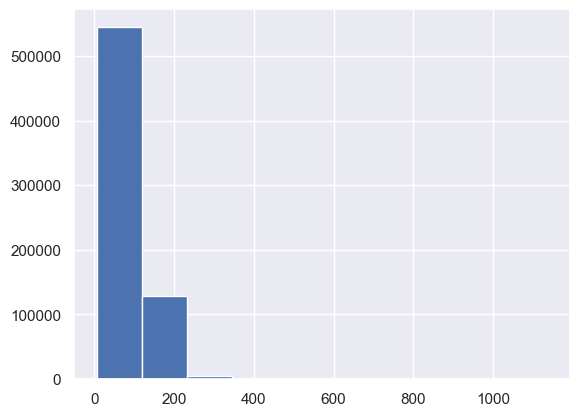

In [39]:
plt.hist(np.concatenate(freq_sev_results["oos_pp"]))

In [49]:
model = RidgeCV(alphas=10.0 ** np.arange(-5, 5))
test_data = df[df["PurePremium"] > 0]
X = trans.fit_transform(test_data)
y = test_data["PurePremium"]
model.fit(X, y)

RidgeCV(alphas=array([1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02,
       1.e+03, 1.e+04]))

In [51]:
model.predict(X)

array([1899.79883705, 1943.43740002, 2255.59212292, ..., 1970.50958206,
       1969.00345786, 1640.55359264])

In [52]:
mean_squared_error(y, model.predict(X))

1004371.8751823513

In [53]:
mean_squared_error(y, np.full_like(y, np.mean(y)))

1055071.497253841

(array([4.84330e+04, 2.09551e+05, 1.54336e+05, 1.07311e+05, 1.07840e+05,
        3.59760e+04, 1.28070e+04, 1.64000e+03, 1.10000e+02, 9.00000e+00]),
 array([1325.74205853, 1486.05350283, 1646.36494713, 1806.67639143,
        1966.98783573, 2127.29928003, 2287.61072434, 2447.92216864,
        2608.23361294, 2768.54505724, 2928.85650154]),
 <BarContainer object of 10 artists>)

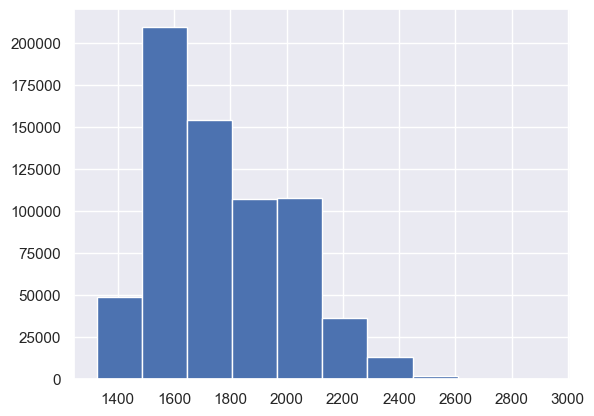

In [57]:
plt.hist(model.predict(trans.transform(df)))

In [58]:
from sklearn.metrics import mean_absolute_error

In [59]:
mean_absolute_error(y, model.predict(X))

876.0746632838648

In [60]:
mean_absolute_error(y, np.full_like(y, np.median(y)))

895.0162161415556

In [61]:
876.0746632838648 / 895.0162161415556

0.9788366372406654

# Bet Taking at Mean and Median

In [110]:
loss_dist = stats.lognorm(s=1)

In [133]:
N = 100000
profits = []
premium = payoff_dist.median()

for n in range(N):
    profit = premium - loss_dist.rvs()
    profits.append(profit)

In [134]:
np.mean(profits)

-0.6515830156553124

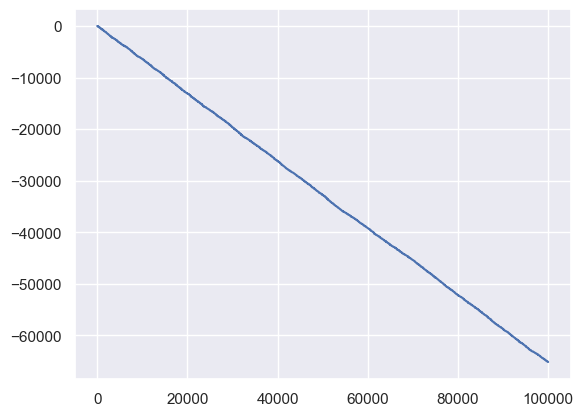

In [135]:
plt.plot(np.cumsum(profits))

In [145]:
N = 100000
profits = []
premium = payoff_dist.mean()

for n in range(N):
    profit = premium - loss_dist.rvs()
    profits.append(profit)

In [146]:
np.mean(profits)

-0.004054353679350595

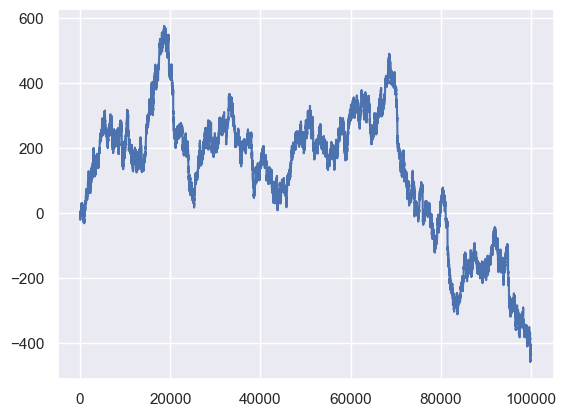

In [147]:
plt.plot(np.cumsum(profits))